# Assignment 2 - Implement your agent

Welcome to Course 4, Programming Assignment 2! We have learned about reinforcement learning algorithms for prediction and control in previous courses and extended those algorithms to large state spaces using function approximation. One example of this was in assignment 2 of course 3 where we implemented semi-gradient TD for prediction and used a neural network as the function approximator. In this notebook, we will build a reinforcement learning agent for control, again using a neural network for function approximation. This combination of neural network function approximators and reinforcement learning algorithms, often referred to as Deep RL, is an active area of research and has led to many impressive results (e. g., AlphaGo: https://deepmind.com/research/case-studies/alphago-the-story-so-far).

**In this assignment, you will:**
  1. Extend the neural network code from assignment 2 of course 3 to output action-values instead of state-values.
  2. Write up the Adam algorithm for neural network optimization.
  3. Understand experience replay buffers.
  4. Implement Softmax action-selection.
  5. Build an Expected Sarsa agent by putting all the pieces together.
  6. Solve Lunar Lander with your agent.

## Packages
- [numpy](www.numpy.org) : Fundamental package for scientific computing with Python.
- [matplotlib](http://matplotlib.org) : Library for plotting graphs in Python.
- [RL-Glue](http://www.jmlr.org/papers/v10/tanner09a.html), BaseEnvironment, BaseAgent : Library and abstract classes to inherit from  for reinforcement learning experiments.
- [LunarLanderEnvironment](https://gym.openai.com/envs/LunarLander-v2/) : An RLGlue environment that wraps a LundarLander environment implementation from OpenAI Gym.
- [collections.deque](https://docs.python.org/3/library/collections.html#collections.deque): a double-ended queue implementation. We use deque to implement the experience replay buffer.
- [copy.deepcopy](https://docs.python.org/3/library/copy.html#copy.deepcopy): As objects are not passed by value in python, we often need to make copies of mutable objects. copy.deepcopy allows us to make a new object with the same contents as another object. (Take a look at this link if you are interested to learn more: https://robertheaton.com/2014/02/09/pythons-pass-by-object-reference-as-explained-by-philip-k-dick/)
- [tqdm](https://github.com/tqdm/tqdm) : A package to display progress bar when running experiments
- [os](https://docs.python.org/3/library/os.html): Package used to interface with the operating system. Here we use it for creating a results folder when it does not exist.
- [shutil](https://docs.python.org/3/library/shutil.html): Package used to operate on files and folders. Here we use it for creating a zip file of the results folder.
- plot_script: Used for plotting learning curves using matplotlib.

In [1]:
# Do not modify this cell!

# Import necessary libraries
# DO NOT IMPORT OTHER LIBRARIES - This will break the autograder.
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from rl_glue import RLGlue
from environment import BaseEnvironment
from lunar_lander import LunarLanderEnvironment
from agent import BaseAgent
from collections import deque
from copy import deepcopy
from tqdm import tqdm
import os 
import shutil
from plot_script import plot_result

## Section 1: Action-Value Network
This section includes the function approximator that we use in our agent, a neural network. In Course 3 Assignment 2, we used a neural network as the function approximator for a policy evaluation problem. In this assignment, we will use a neural network for approximating the action-value function in a control problem. The main difference between approximating a state-value function and an action-value function using a neural network is that in the former the output layer only includes one unit whereas in the latter the output layer includes as many units as the number of actions. 

In the cell below, you will specify the architecture of the action-value neural network. More specifically, you will specify `self.layer_sizes` in the `__init__()` function. 

We have already provided `get_action_values()` and `get_TD_update()` methods. The former computes the action-value function by doing a forward pass and the latter computes the gradient of the action-value function with respect to the weights times the TD error. These `get_action_values()` and `get_TD_update()` methods are similar to the `get_value()` and `get_gradient()` methods that you implemented in Course 3 Assignment 2. The main difference is that in this notebook, they are designed to be applied to batches of states instead of one state. You will later use these functions for implementing the agent.

In [2]:
# -----------
# Graded Cell
# -----------

# Work Required: Yes. Fill in the code for layer_sizes in __init__ (~1 Line). 
# Also go through the rest of the code to ensure your understanding is correct.
class ActionValueNetwork:
    # Work Required: Yes. Fill in the layer_sizes member variable (~1 Line).
    def __init__(self, network_config):
        self.state_dim = network_config.get("state_dim")
        self.num_hidden_units = network_config.get("num_hidden_units")
        self.num_actions = network_config.get("num_actions")
        
        self.rand_generator = np.random.RandomState(network_config.get("seed"))
        
        # Specify self.layer_sizes which shows the number of nodes in each layer
        # your code here
        self.layer_sizes = np.array([self.state_dim, self.num_hidden_units, self.num_actions])
        
        # Initialize the weights of the neural network
        # self.weights is an array of dictionaries with each dictionary corresponding to 
        # the weights from one layer to the next. Each dictionary includes W and b
        self.weights = [dict() for i in range(0, len(self.layer_sizes) - 1)]
        for i in range(0, len(self.layer_sizes) - 1):
            self.weights[i]['W'] = self.init_saxe(self.layer_sizes[i], self.layer_sizes[i + 1])
            self.weights[i]['b'] = np.zeros((1, self.layer_sizes[i + 1]))
    
    # Work Required: No.
    def get_action_values(self, s):
        """
        Args:
            s (Numpy array): The state.
        Returns:
            The action-values (Numpy array) calculated using the network's weights.
        """
        
        W0, b0 = self.weights[0]['W'], self.weights[0]['b']
        psi = np.dot(s, W0) + b0
        x = np.maximum(psi, 0)
        
        W1, b1 = self.weights[1]['W'], self.weights[1]['b']
        q_vals = np.dot(x, W1) + b1

        return q_vals
    
    # Work Required: No.
    def get_TD_update(self, s, delta_mat):
        """
        Args:
            s (Numpy array): The state.
            delta_mat (Numpy array): A 2D array of shape (batch_size, num_actions). Each row of delta_mat  
            correspond to one state in the batch. Each row has only one non-zero element 
            which is the TD-error corresponding to the action taken.
        Returns:
            The TD update (Array of dictionaries with gradient times TD errors) for the network's weights
        """

        W0, b0 = self.weights[0]['W'], self.weights[0]['b']
        W1, b1 = self.weights[1]['W'], self.weights[1]['b']
        
        psi = np.dot(s, W0) + b0
        x = np.maximum(psi, 0)
        dx = (psi > 0).astype(float)

        # td_update has the same structure as self.weights, that is an array of dictionaries.
        # td_update[0]["W"], td_update[0]["b"], td_update[1]["W"], and td_update[1]["b"] have the same shape as 
        # self.weights[0]["W"], self.weights[0]["b"], self.weights[1]["W"], and self.weights[1]["b"] respectively
        td_update = [dict() for i in range(len(self.weights))]
         
        v = delta_mat
        td_update[1]['W'] = np.dot(x.T, v) * 1. / s.shape[0]
        td_update[1]['b'] = np.sum(v, axis=0, keepdims=True) * 1. / s.shape[0]
        
        v = np.dot(v, W1.T) * dx
        td_update[0]['W'] = np.dot(s.T, v) * 1. / s.shape[0]
        td_update[0]['b'] = np.sum(v, axis=0, keepdims=True) * 1. / s.shape[0]
                
        return td_update
    
    # Work Required: No. You may wish to read the relevant paper for more information on this weight initialization
    # (Exact solutions to the nonlinear dynamics of learning in deep linear neural networks by Saxe, A et al., 2013)
    def init_saxe(self, rows, cols):
        """
        Args:
            rows (int): number of input units for layer.
            cols (int): number of output units for layer.
        Returns:
            NumPy Array consisting of weights for the layer based on the initialization in Saxe et al.
        """
        tensor = self.rand_generator.normal(0, 1, (rows, cols))
        if rows < cols:
            tensor = tensor.T
        tensor, r = np.linalg.qr(tensor)
        d = np.diag(r, 0)
        ph = np.sign(d)
        tensor *= ph

        if rows < cols:
            tensor = tensor.T
        return tensor
    
    # Work Required: No.
    def get_weights(self):
        """
        Returns: 
            A copy of the current weights of this network.
        """
        return deepcopy(self.weights)
    
    # Work Required: No.
    def set_weights(self, weights):
        """
        Args: 
            weights (list of dictionaries): Consists of weights that this network will set as its own weights.
        """
        self.weights = deepcopy(weights)

Run the cell below to test your implementation of the `__init__()` function for ActionValueNetwork:

In [3]:
# --------------
# Debugging Cell
# --------------
# Feel free to make any changes to this cell to debug your code

network_config = {
    "state_dim": 5,
    "num_hidden_units": 20,
    "num_actions": 3
}

test_network = ActionValueNetwork(network_config)
print("layer_sizes:", test_network.layer_sizes)
assert(np.allclose(test_network.layer_sizes, np.array([5, 20, 3])))

layer_sizes: [ 5 20  3]


In [4]:
# -----------
# Tested Cell
# -----------
# The contents of the cell will be tested by the autograder.
# If they do not pass here, they will not pass there.

rand_generator = np.random.RandomState(0)
for _ in range(1000):
    network_config = {
        "state_dim": rand_generator.randint(2, 10),
        "num_hidden_units": rand_generator.randint(2, 1024),
        "num_actions": rand_generator.randint(2, 10)
    }

    test_network = ActionValueNetwork(network_config)

    assert(np.allclose(test_network.layer_sizes, np.array([network_config["state_dim"], 
                                                           network_config["num_hidden_units"], 
                                                           network_config["num_actions"]])))

**Expected output:** (assuming no changes to the debugging cell)

    layer_sizes: [ 5 20  3]

## Section 2: Adam Optimizer

In this assignment, you will use the Adam algorithm for updating the weights of your action-value network. As you may remember from Course 3 Assignment 2, the Adam algorithm is a more advanced variant of stochastic gradient descent (SGD). The Adam algorithm improves the SGD update with two concepts: adaptive vector stepsizes and momentum. It keeps running estimates of the mean and second moment of the updates, denoted by $\mathbf{m}$ and $\mathbf{v}$ respectively:
$$\mathbf{m_t} = \beta_m \mathbf{m_{t-1}} + (1 - \beta_m)g_t \\
\mathbf{v_t} = \beta_v \mathbf{v_{t-1}} + (1 - \beta_v)g^2_t
$$

Here, $\beta_m$ and $\beta_v$ are fixed parameters controlling the linear combinations above and $g_t$ is the update at time $t$ (generally the gradients, but here the TD error times the gradients).

Given that $\mathbf{m}$ and $\mathbf{v}$ are initialized to zero, they are biased toward zero. To get unbiased estimates of the mean and second moment, Adam defines $\mathbf{\hat{m}}$ and $\mathbf{\hat{v}}$ as:
$$ \mathbf{\hat{m}_t} = \frac{\mathbf{m_t}}{1 - \beta_m^t} \\
\mathbf{\hat{v}_t} = \frac{\mathbf{v_t}}{1 - \beta_v^t}
$$

The weights are then updated as follows:
$$ \mathbf{w_t} = \mathbf{w_{t-1}} + \frac{\alpha}{\sqrt{\mathbf{\hat{v}_t}}+\epsilon} \mathbf{\hat{m}_t}
$$

Here, $\alpha$ is the step size parameter and $\epsilon$ is another small parameter to keep the denominator from being zero.

In the cell below, you will implement the `__init__()` and `update_weights()` methods for the Adam algorithm. In `__init__()`, you will initialize `self.m` and `self.v`. In `update_weights()`, you will compute new weights given the input weights and an update $g$ (here `td_errors_times_gradients`) according to the equations above.

In [5]:
### Work Required: Yes. Fill in code in __init__ and update_weights (~9-11 Lines).
class Adam():
    # Work Required: Yes. Fill in the initialization for self.m and self.v (~4 Lines).
    def __init__(self, layer_sizes, 
                 optimizer_info):
        self.layer_sizes = layer_sizes

        # Specify Adam algorithm's hyper parameters
        self.step_size = optimizer_info.get("step_size")
        self.beta_m = optimizer_info.get("beta_m")
        self.beta_v = optimizer_info.get("beta_v")
        self.epsilon = optimizer_info.get("epsilon")
        
        # Initialize Adam algorithm's m and v
        self.m = [dict() for i in range(1, len(self.layer_sizes))]
        self.v = [dict() for i in range(1, len(self.layer_sizes))]
        
        for i in range(0, len(self.layer_sizes) - 1):
            # Hint: The initialization for m and v should look very much like the initializations of the weights
            # except for the fact that initialization here is to zeroes (see description above.)
            # Replace the None in each following line
            
            self.m[i]["W"] = np.zeros((self.layer_sizes[i], self.layer_sizes[i+1]))
            self.m[i]["b"] = np.zeros((1, self.layer_sizes[i+1]))
            self.v[i]["W"] = np.zeros((self.layer_sizes[i], self.layer_sizes[i+1]))
            self.v[i]["b"] = np.zeros((1, self.layer_sizes[i+1]))
            
            # your code here
            
            
        # Notice that to calculate m_hat and v_hat, we use powers of beta_m and beta_v to 
        # the time step t. We can calculate these powers using an incremental product. At initialization then, 
        # beta_m_product and beta_v_product should be ...? (Note that timesteps start at 1 and if we were to 
        # start from 0, the denominator would be 0.)
        self.beta_m_product = self.beta_m
        self.beta_v_product = self.beta_v
    
    # Work Required: Yes. Fill in the weight updates (~5-7 lines).
    def update_weights(self, weights, td_errors_times_gradients):
        """
        Args:
            weights (Array of dictionaries): The weights of the neural network.
            td_errors_times_gradients (Array of dictionaries): The gradient of the 
            action-values with respect to the network's weights times the TD-error
        Returns:
            The updated weights (Array of dictionaries).
        """
        for i in range(len(weights)):
            for param in weights[i].keys():
                # Hint: Follow the equations above. First, you should update m and v and then compute 
                # m_hat and v_hat. Finally, compute how much the weights should be incremented by.
                # self.m[i][param] = None
                # self.v[i][param] = None
                # m_hat = None
                # v_hat = None
                self.m[i][param] = self.beta_m * self.m[i][param] + (1 - self.beta_m) * td_errors_times_gradients[i][param]
                self.v[i][param] = self.beta_v * self.v[i][param] + (1 - self.beta_v) * (td_errors_times_gradients[i][param] ** 2)
                
                m_hat = self.m[i][param] / (1 - self.beta_m_product)
                v_hat = self.v[i][param] / (1 - self.beta_v_product)
                
                ### update weights
                weight_update = self.step_size * m_hat / (np.sqrt(v_hat) + self.epsilon)
                
                # your code here
                
                
                weights[i][param] = weights[i][param] + weight_update
        # Notice that to calculate m_hat and v_hat, we use powers of beta_m and beta_v to 
        ### update self.beta_m_product and self.beta_v_product
        self.beta_m_product *= self.beta_m
        self.beta_v_product *= self.beta_v
        
        return weights

Run the following code to test your implementation of the `__init__()` function:

In [6]:
# --------------
# Debugging Cell
# --------------
# Feel free to make any changes to this cell to debug your code

network_config = {"state_dim": 5,
                  "num_hidden_units": 2,
                  "num_actions": 3
                 }

optimizer_info = {"step_size": 0.1,
                  "beta_m": 0.99,
                  "beta_v": 0.999,
                  "epsilon": 0.0001
                 }

network = ActionValueNetwork(network_config)
test_adam = Adam(network.layer_sizes, optimizer_info)

print("m[0][\"W\"] shape: {}".format(test_adam.m[0]["W"].shape))
print("m[0][\"b\"] shape: {}".format(test_adam.m[0]["b"].shape))
print("m[1][\"W\"] shape: {}".format(test_adam.m[1]["W"].shape))
print("m[1][\"b\"] shape: {}".format(test_adam.m[1]["b"].shape), "\n")

assert(np.allclose(test_adam.m[0]["W"].shape, np.array([5, 2])))
assert(np.allclose(test_adam.m[0]["b"].shape, np.array([1, 2])))
assert(np.allclose(test_adam.m[1]["W"].shape, np.array([2, 3])))
assert(np.allclose(test_adam.m[1]["b"].shape, np.array([1, 3])))

print("v[0][\"W\"] shape: {}".format(test_adam.v[0]["W"].shape))
print("v[0][\"b\"] shape: {}".format(test_adam.v[0]["b"].shape))
print("v[1][\"W\"] shape: {}".format(test_adam.v[1]["W"].shape))
print("v[1][\"b\"] shape: {}".format(test_adam.v[1]["b"].shape), "\n")

assert(np.allclose(test_adam.v[0]["W"].shape, np.array([5, 2])))
assert(np.allclose(test_adam.v[0]["b"].shape, np.array([1, 2])))
assert(np.allclose(test_adam.v[1]["W"].shape, np.array([2, 3])))
assert(np.allclose(test_adam.v[1]["b"].shape, np.array([1, 3])))

assert(np.all(test_adam.m[0]["W"]==0))
assert(np.all(test_adam.m[0]["b"]==0))
assert(np.all(test_adam.m[1]["W"]==0))
assert(np.all(test_adam.m[1]["b"]==0))

assert(np.all(test_adam.v[0]["W"]==0))
assert(np.all(test_adam.v[0]["b"]==0))
assert(np.all(test_adam.v[1]["W"]==0))
assert(np.all(test_adam.v[1]["b"]==0))

m[0]["W"] shape: (5, 2)
m[0]["b"] shape: (1, 2)
m[1]["W"] shape: (2, 3)
m[1]["b"] shape: (1, 3) 

v[0]["W"] shape: (5, 2)
v[0]["b"] shape: (1, 2)
v[1]["W"] shape: (2, 3)
v[1]["b"] shape: (1, 3) 



In [7]:
# -----------
# Tested Cell
# -----------
# The contents of the cell will be tested by the autograder.
# If they do not pass here, they will not pass there.



# import our implementation of Adam
# while you can go look at this for the answer, try to solve the programming challenge yourself first
from tests import TrueAdam

rand_generator = np.random.RandomState(0)
for _ in range(1000):
    network_config = {
        "state_dim": rand_generator.randint(2, 10),
        "num_hidden_units": rand_generator.randint(2, 1024),
        "num_actions": rand_generator.randint(2, 10)
    }
    
    optimizer_info = {"step_size": rand_generator.choice(np.geomspace(0.1, 1e-5, num=5)),
                  "beta_m": rand_generator.choice([0.9, 0.99, 0.999, 0.9999, 0.99999]),
                  "beta_v": rand_generator.choice([0.9, 0.99, 0.999, 0.9999, 0.99999]),
                  "epsilon": rand_generator.choice(np.geomspace(0.1, 1e-5, num=5))
                 }

    test_network = ActionValueNetwork(network_config)
    test_adam = Adam(test_network.layer_sizes, optimizer_info)
    true_adam = TrueAdam(test_network.layer_sizes, optimizer_info)
    
    assert(np.allclose(test_adam.m[0]["W"].shape, true_adam.m[0]["W"].shape))
    assert(np.allclose(test_adam.m[0]["b"].shape, true_adam.m[0]["b"].shape))
    assert(np.allclose(test_adam.m[1]["W"].shape, true_adam.m[1]["W"].shape))
    assert(np.allclose(test_adam.m[1]["b"].shape, true_adam.m[1]["b"].shape))

    assert(np.allclose(test_adam.v[0]["W"].shape, true_adam.v[0]["W"].shape))
    assert(np.allclose(test_adam.v[0]["b"].shape, true_adam.v[0]["b"].shape))
    assert(np.allclose(test_adam.v[1]["W"].shape, true_adam.v[1]["W"].shape))
    assert(np.allclose(test_adam.v[1]["b"].shape, true_adam.v[1]["b"].shape))

    assert(np.all(test_adam.m[0]["W"]==0))
    assert(np.all(test_adam.m[0]["b"]==0))
    assert(np.all(test_adam.m[1]["W"]==0))
    assert(np.all(test_adam.m[1]["b"]==0))

    assert(np.all(test_adam.v[0]["W"]==0))
    assert(np.all(test_adam.v[0]["b"]==0))
    assert(np.all(test_adam.v[1]["W"]==0))
    assert(np.all(test_adam.v[1]["b"]==0))
    
    assert(test_adam.beta_m_product == optimizer_info["beta_m"])
    assert(test_adam.beta_v_product == optimizer_info["beta_v"])

**Expected output:**

    m[0]["W"] shape: (5, 2)
    m[0]["b"] shape: (1, 2)
    m[1]["W"] shape: (2, 3)
    m[1]["b"] shape: (1, 3) 

    v[0]["W"] shape: (5, 2)
    v[0]["b"] shape: (1, 2)
    v[1]["W"] shape: (2, 3)
    v[1]["b"] shape: (1, 3) 

## Section 3: Experience Replay Buffers

In Course 3, you implemented agents that update value functions once for each sample. We can use a more efficient approach for updating value functions. You have seen an example of an efficient approach in Course 2 when implementing Dyna. The idea behind Dyna is to learn a model using sampled experience, obtain simulated experience from the model, and improve the value function using the simulated experience.

Experience replay is a simple method that can get some of the advantages of Dyna by saving a buffer of experience and using the data stored in the buffer as a model. This view of prior data as a model works because the data represents actual transitions from the underlying MDP. Furthermore, as a side note, this kind of model that is not learned and simply a collection of experience can be called non-parametric as it can be ever-growing as opposed to a parametric model where the transitions are learned to be represented with a fixed set of parameters or weights.

We have provided the implementation of the experience replay buffer in the cell below. ReplayBuffer includes two main functions: `append()` and `sample()`. `append()` adds an experience transition to the buffer as an array that includes the state, action, reward, terminal flag (indicating termination of the episode), and next_state. `sample()` gets a batch of experiences from the buffer with size `minibatch_size`.

You will use the `append()` and `sample()` functions when implementing the agent.

In [8]:
# ---------------
# Discussion Cell
# ---------------

class ReplayBuffer:
    def __init__(self, size, minibatch_size, seed):
        """
        Args:
            size (integer): The size of the replay buffer.              
            minibatch_size (integer): The sample size.
            seed (integer): The seed for the random number generator. 
        """
        self.buffer = []
        self.minibatch_size = minibatch_size
        self.rand_generator = np.random.RandomState(seed)
        self.max_size = size

    def append(self, state, action, reward, terminal, next_state):
        """
        Args:
            state (Numpy array): The state.              
            action (integer): The action.
            reward (float): The reward.
            terminal (integer): 1 if the next state is a terminal state and 0 otherwise.
            next_state (Numpy array): The next state.           
        """
        if len(self.buffer) == self.max_size:
            del self.buffer[0]
        self.buffer.append([state, action, reward, terminal, next_state])

    def sample(self):
        """
        Returns:
            A list of transition tuples including state, action, reward, terinal, and next_state
        """
        idxs = self.rand_generator.choice(np.arange(len(self.buffer)), size=self.minibatch_size)
        return [self.buffer[idx] for idx in idxs]

    def size(self):
        return len(self.buffer)

## Section 4: Softmax Policy

In this assignment, you will use a softmax policy. One advantage of a softmax policy is that it explores according to the action-values, meaning that an action with a moderate value has a higher chance of getting selected compared to an action with a lower value. Contrast this with an $\epsilon$-greedy policy which does not consider the individual action values when choosing an exploratory action in a state and instead chooses randomly when doing so.

The probability of selecting each action according to the softmax policy is shown below:
$$Pr{(A_t=a | S_t=s)} \hspace{0.1cm} \dot{=} \hspace{0.1cm} \frac{e^{Q(s, a)/\tau}}{\sum_{b \in A}e^{Q(s, b)/\tau}}$$
where $\tau$ is the temperature parameter which controls how much the agent focuses on the highest valued actions. The smaller the temperature, the more the agent selects the greedy action. Conversely, when the temperature is high, the agent selects among actions more uniformly random.

Given that a softmax policy exponentiates action values, if those values are large, exponentiating them could get very large. To implement the softmax policy in a numerically stable way, we often subtract the maximum action-value from the action-values. If we do so, the probability of selecting each action looks as follows:

$$Pr{(A_t=a | S_t=s)} \hspace{0.1cm} \dot{=} \hspace{0.1cm} \frac{e^{Q(s, a)/\tau - max_{c}Q(s, c)/\tau}}{\sum_{b \in A}e^{Q(s, b)/\tau - max_{c}Q(s, c)/\tau}}$$

In the cell below, you will implement the `softmax()` function. In order to do so, you could break the above computation into smaller steps:
- compute the preference, $H(a)$, for taking each action by dividing the action-values by the temperature parameter $\tau$,
- subtract the maximum preference across the actions from the preferences to avoid overflow, and,
- compute the probability of taking each action.

In [9]:
# -----------
# Graded Cell
# -----------

def softmax(action_values, tau=1.0):
    """
    Args:
        action_values (Numpy array): A 2D array of shape (batch_size, num_actions). 
                       The action-values computed by an action-value network.              
        tau (float): The temperature parameter scalar.
    Returns:
        A 2D array of shape (batch_size, num_actions). Where each column is a probability distribution over
        the actions representing the policy.
    """
    
    # Compute the preferences by dividing the action-values by the temperature parameter tau
    preferences = None
    # Compute the maximum preference across the actions
    max_preference = None
    
    # your code here
    preferences = action_values / tau
    max_preference = np.max(preferences, axis=1)
    
    
    # Reshape max_preference array which has shape [Batch,] to [Batch, 1]. This allows NumPy broadcasting 
    # when subtracting the maximum preference from the preference of each action.
    reshaped_max_preference = max_preference.reshape((-1, 1))
    
    # Compute the numerator, i.e., the exponential of the preference - the max preference.
    exp_preferences = None
    # Compute the denominator, i.e., the sum over the numerator along the actions axis.
    sum_of_exp_preferences = None
    
    # your code here
    exp_preferences = np.exp(preferences - reshaped_max_preference)
    sum_of_exp_preferences = np.sum(exp_preferences, axis=1)
    
    
    # Reshape sum_of_exp_preferences array which has shape [Batch,] to [Batch, 1] to  allow for NumPy broadcasting 
    # when dividing the numerator by the denominator.
    reshaped_sum_of_exp_preferences = sum_of_exp_preferences.reshape((-1, 1))
    
    # Compute the action probabilities according to the equation in the previous cell.
    action_probs = None
    
    # your code here
    action_probs = exp_preferences / reshaped_sum_of_exp_preferences
    
    
    # squeeze() removes any singleton dimensions. It is used here because this function is used in the 
    # agent policy when selecting an action (for which the batch dimension is 1.) As np.random.choice is used in 
    # the agent policy and it expects 1D arrays, we need to remove this singleton batch dimension.
    action_probs = action_probs.squeeze()
    return action_probs

Run the cell below to test your implementation of the `softmax()` function:

In [10]:
# --------------
# Debugging Cell
# --------------
# Feel free to make any changes to this cell to debug your code

rand_generator = np.random.RandomState(0)
action_values = rand_generator.normal(0, 1, (2, 4))
tau = 0.5

action_probs = softmax(action_values, tau)
print("action_probs", action_probs)

assert(np.allclose(action_probs, np.array([
    [0.25849645, 0.01689625, 0.05374514, 0.67086216],
    [0.84699852, 0.00286345, 0.13520063, 0.01493741]
])))

print("Passed the asserts! (Note: These are however limited in scope, additional testing is encouraged.)")

action_probs [[0.25849645 0.01689625 0.05374514 0.67086216]
 [0.84699852 0.00286345 0.13520063 0.01493741]]
Passed the asserts! (Note: These are however limited in scope, additional testing is encouraged.)


In [11]:
# -----------
# Tested Cell
# -----------
# The contents of the cell will be tested by the autograder.
# If they do not pass here, they will not pass there.

from tests import __true__softmax

rand_generator = np.random.RandomState(0)
for _ in range(1000):
    action_values = rand_generator.normal(0, 1, (rand_generator.randint(1, 5), 4))
    tau = rand_generator.rand()
    assert(np.allclose(softmax(action_values, tau), __true__softmax(action_values, tau)))

**Expected output:**

    action_probs [[0.25849645 0.01689625 0.05374514 0.67086216]
     [0.84699852 0.00286345 0.13520063 0.01493741]]

## Section 5: Putting the pieces together

In this section, you will combine components from the previous sections to write up an RL-Glue Agent. The main component that you will implement is the action-value network updates with experience sampled from the experience replay buffer.

At time $t$, we have an action-value function represented as a neural network, say $Q_t$. We want to update our action-value function and get a new one we can use at the next timestep. We will get this $Q_{t+1}$ using multiple replay steps that each result in an intermediate action-value function $Q_{t+1}^{i}$ where $i$ indexes which replay step we are at.

In each replay step, we sample a batch of experiences from the replay buffer and compute a minibatch Expected-SARSA update. Across these N replay steps, we will use the current "un-updated" action-value network at time $t$, $Q_t$, for computing the action-values of the next-states. This contrasts using the most recent action-values from the last replay step $Q_{t+1}^{i}$. We make this choice to have targets that are stable across replay steps. Here is the pseudocode for performing the updates:

$$
\begin{align}
& Q_t \leftarrow \text{action-value network at timestep t (current action-value network)}\\
& \text{Initialize } Q_{t+1}^1 \leftarrow Q_t\\
& \text{For } i \text{ in } [1, ..., N] \text{ (i.e. N} \text{  replay steps)}:\\
& \hspace{1cm} s, a, r, t, s'
\leftarrow \text{Sample batch of experiences from experience replay buffer} \\
& \hspace{1cm} \text{Do Expected Sarsa update with } Q_t: Q_{t+1}^{i+1}(s, a) \leftarrow Q_{t+1}^{i}(s, a) + \alpha \cdot \left[r + \gamma \left(\sum_{b} \pi(b | s') Q_t(s', b)\right) - Q_{t+1}^{i}(s, a)\right]\\
& \hspace{1.5cm} \text{ making sure to add the } \gamma \left(\sum_{b} \pi(b | s') Q_t(s', b)\right) \text{ for non-terminal transitions only.} \\
& \text{After N replay steps, we set } Q_{t+1}^{N} \text{ as } Q_{t+1} \text{ and have a new } Q_{t+1} \text{for time step } t + 1 \text{ that we will fix in the next set of updates. }
\end{align}
$$

As you can see in the pseudocode, after sampling a batch of experiences, we do many computations. The basic idea however is that we are looking to compute a form of a TD error. In order to so, we can take the following steps:
- compute the action-values for the next states using the action-value network $Q_{t}$,
- compute the policy $\pi(b | s')$ induced by the action-values $Q_{t}$ (using the softmax function you implemented before),
- compute the Expected sarsa targets $r + \gamma \left(\sum_{b} \pi(b | s') Q_t(s', b)\right)$,
- compute the action-values for the current states using the latest $Q_{t + 1}$, and,
- compute the TD-errors with the Expected Sarsa targets.
 
For the third step above, you can start by computing $\pi(b | s') Q_t(s', b)$ followed by summation to get $\hat{v}_\pi(s') = \left(\sum_{b} \pi(b | s') Q_t(s', b)\right)$. $\hat{v}_\pi(s')$ is an estimate of the value of the next state. Note for terminal next states, $\hat{v}_\pi(s') = 0$. Finally, we add the rewards to the discount times $\hat{v}_\pi(s')$.

You will implement these steps in the `get_td_error()` function below which given a batch of experiences (including states, next_states, actions, rewards, terminals), fixed action-value network (current_q), and action-value network (network), computes the TD error in the form of a 1D array of size batch_size.

In [12]:
### Work Required: Yes. Fill in code in get_td_error (~9 Lines).
def get_td_error(states, next_states, actions, rewards, discount, terminals, network, current_q, tau):
    """
    Args:
        states (Numpy array): The batch of states with the shape (batch_size, state_dim).
        next_states (Numpy array): The batch of next states with the shape (batch_size, state_dim).
        actions (Numpy array): The batch of actions with the shape (batch_size,).
        rewards (Numpy array): The batch of rewards with the shape (batch_size,).
        discount (float): The discount factor.
        terminals (Numpy array): The batch of terminals with the shape (batch_size,).
        network (ActionValueNetwork): The latest state of the network that is getting replay updates.
        current_q (ActionValueNetwork): The fixed network used for computing the targets, 
                                        and particularly, the action-values at the next-states.
    Returns:
        The TD errors (Numpy array) for actions taken, of shape (batch_size,)
    """
    
    # Note: Here network is the latest state of the network that is getting replay updates. In other words, 
    # the network represents Q_{t+1}^{i} whereas current_q represents Q_t, the fixed network used for computing the 
    # targets, and particularly, the action-values at the next-states.
    
    # Compute action values at next states using current_q network
    # Note that q_next_mat is a 2D array of shape (batch_size, num_actions)
    
    ### START CODE HERE (~1 Line)
    q_next_mat = current_q.get_action_values(next_states)
    ### END CODE HERE
    # your code here
    
    
    # Compute policy at next state by passing the action-values in q_next_mat to softmax()
    # Note that probs_mat is a 2D array of shape (batch_size, num_actions)
    
    ### START CODE HERE (~1 Line)
    probs_mat = softmax(q_next_mat, tau)
    ### END CODE HERE
    # your code here
    
    
    # Compute the estimate of the next state value, v_next_vec.
    # Hint: sum the action-values for the next_states weighted by the policy, probs_mat. Then, multiply by
    # (1 - terminals) to make sure v_next_vec is zero for terminal next states.
    # Note that v_next_vec is a 1D array of shape (batch_size,)
    
    ### START CODE HERE (~3 Lines)
    v_next_vec = np.sum(probs_mat * q_next_mat, axis=1) * (1 - terminals)
    ### END CODE HERE
    # your code here
    
    
    # Compute Expected Sarsa target
    # Note that target_vec is a 1D array of shape (batch_size,)
    
    ### START CODE HERE (~1 Line)
    target_vec = rewards + discount * v_next_vec
    ### END CODE HERE
    # your code here
    
    
    # Compute action values at the current states for all actions using network
    # Note that q_mat is a 2D array of shape (batch_size, num_actions)
    
    ### START CODE HERE (~1 Line)
    q_mat = network.get_action_values(states)
    ### END CODE HERE
    # your code here
    
    
    # Batch Indices is an array from 0 to the batch size - 1. 
    batch_indices = np.arange(q_mat.shape[0])

    # Compute q_vec by selecting q(s, a) from q_mat for taken actions
    # Use batch_indices as the index for the first dimension of q_mat
    # Note that q_vec is a 1D array of shape (batch_size)
    
    ### START CODE HERE (~1 Line)
    q_vec = q_mat[batch_indices, actions]
    ### END CODE HERE
    # your code here
    
    
    # Compute TD errors for actions taken
    # Note that delta_vec is a 1D array of shape (batch_size)
    
    ### START CODE HERE (~1 Line)
    delta_vec = target_vec - q_vec
    ### END CODE HERE
    # your code here
    
    
    return delta_vec

Run the following code to test your implementation of the `get_td_error()` function:

In [13]:
# --------------
# Debugging Cell
# --------------
# Feel free to make any changes to this cell to debug your code

data = np.load("asserts/get_td_error_1.npz", allow_pickle=True)

states = data["states"]
next_states = data["next_states"]
actions = data["actions"]
rewards = data["rewards"]
discount = data["discount"]
terminals = data["terminals"]
tau = 0.001

network_config = {"state_dim": 8,
                  "num_hidden_units": 512,
                  "num_actions": 4
                  }

network = ActionValueNetwork(network_config)
network.set_weights(data["network_weights"])

current_q = ActionValueNetwork(network_config)
current_q.set_weights(data["current_q_weights"])

delta_vec = get_td_error(states, next_states, actions, rewards, discount, terminals, network, current_q, tau)
answer_delta_vec = data["delta_vec"]

assert(np.allclose(delta_vec, answer_delta_vec))
print("Passed the asserts! (Note: These are however limited in scope, additional testing is encouraged.)")

Passed the asserts! (Note: These are however limited in scope, additional testing is encouraged.)


In [14]:
# -----------
# Tested Cell
# -----------
# The contents of the cell will be tested by the autograder.
# If they do not pass here, they will not pass there.

data = np.load("asserts/get_td_error_1.npz", allow_pickle=True)

states = data["states"]
next_states = data["next_states"]
actions = data["actions"]
rewards = data["rewards"]
discount = data["discount"]
terminals = data["terminals"]
tau = 0.001

network_config = {"state_dim": 8,
                  "num_hidden_units": 512,
                  "num_actions": 4
                  }

network = ActionValueNetwork(network_config)
network.set_weights(data["network_weights"])

current_q = ActionValueNetwork(network_config)
current_q.set_weights(data["current_q_weights"])

delta_vec = get_td_error(states, next_states, actions, rewards, discount, terminals, network, current_q, tau)
answer_delta_vec = data["delta_vec"]

assert(np.allclose(delta_vec, answer_delta_vec))

Now that you implemented the `get_td_error()` function, you can use it to implement the `optimize_network()` function. In this function, you will:
- get the TD-errors vector from `get_td_error()`,
- make the TD-errors into a matrix using zeroes for actions not taken in the transitions,
- pass the TD-errors matrix to the `get_TD_update()` function of network to calculate the gradients times TD errors, and,
- perform an ADAM optimizer step.

In [15]:
# -----------
# Graded Cell
# -----------

### Work Required: Yes. Fill in code in optimize_network (~2 Lines).
def optimize_network(experiences, discount, optimizer, network, current_q, tau):
    """
    Args:
        experiences (Numpy array): The batch of experiences including the states, actions, 
                                   rewards, terminals, and next_states.
        discount (float): The discount factor.
        network (ActionValueNetwork): The latest state of the network that is getting replay updates.
        current_q (ActionValueNetwork): The fixed network used for computing the targets, 
                                        and particularly, the action-values at the next-states.
    """
    
    # Get states, action, rewards, terminals, and next_states from experiences
    states, actions, rewards, terminals, next_states = map(list, zip(*experiences))
    states = np.concatenate(states)
    next_states = np.concatenate(next_states)
    rewards = np.array(rewards)
    terminals = np.array(terminals)
    batch_size = states.shape[0]

    # Compute TD error using the get_td_error function
    # Note that q_vec is a 1D array of shape (batch_size)
    delta_vec = get_td_error(states, next_states, actions, rewards, discount, terminals, network, current_q, tau)

    # Batch Indices is an array from 0 to the batch_size - 1. 
    batch_indices = np.arange(batch_size)

    # Make a td error matrix of shape (batch_size, num_actions)
    # delta_mat has non-zero value only for actions taken
    delta_mat = np.zeros((batch_size, network.num_actions))
    delta_mat[batch_indices, actions] = delta_vec

    # Pass delta_mat to compute the TD errors times the gradients of the network's weights from back-propagation
    
    ### START CODE HERE
    td_update = network.get_TD_update(states, delta_mat)
    ### END CODE HERE
    # your code here
    
    
    # Pass network.get_weights and the td_update to the optimizer to get updated weights
    ### START CODE HERE
    weights = optimizer.update_weights(network.get_weights(), td_update)
    ### END CODE HERE
    # your code here
    
    
    network.set_weights(weights)

Run the following code to test your implementation of the `optimize_network()` function:

In [16]:
# -----------
# Tested Cell
# -----------
# The contents of the cell will be tested by the autograder.
# If they do not pass here, they will not pass there.

input_data = np.load("asserts/optimize_network_input_1.npz", allow_pickle=True)

experiences = list(input_data["experiences"])
discount = input_data["discount"]
tau = 0.001

network_config = {"state_dim": 8,
                  "num_hidden_units": 512,
                  "num_actions": 4
                  }

network = ActionValueNetwork(network_config)
network.set_weights(input_data["network_weights"])

current_q = ActionValueNetwork(network_config)
current_q.set_weights(input_data["current_q_weights"])

optimizer_config = {'step_size': 3e-5, 
                    'beta_m': 0.9, 
                    'beta_v': 0.999,
                    'epsilon': 1e-8
                   }
optimizer = Adam(network.layer_sizes, optimizer_config)
optimizer.m = input_data["optimizer_m"]
optimizer.v = input_data["optimizer_v"]
optimizer.beta_m_product = input_data["optimizer_beta_m_product"]
optimizer.beta_v_product = input_data["optimizer_beta_v_product"]

optimize_network(experiences, discount, optimizer, network, current_q, tau)
updated_weights = network.get_weights()

output_data = np.load("asserts/optimize_network_output_1.npz", allow_pickle=True)
answer_updated_weights = output_data["updated_weights"]

assert(np.allclose(updated_weights[0]["W"], answer_updated_weights[0]["W"]))
assert(np.allclose(updated_weights[0]["b"], answer_updated_weights[0]["b"]))
assert(np.allclose(updated_weights[1]["W"], answer_updated_weights[1]["W"]))
assert(np.allclose(updated_weights[1]["b"], answer_updated_weights[1]["b"]))

Now that you implemented the `optimize_network()` function, you can implement the agent. In the cell below, you will fill the `agent_step()` and `agent_end()` functions. You should:
- select an action (only in `agent_step()`),
- add transitions (consisting of the state, action, reward, terminal, and next state) to the replay buffer, and,
- update the weights of the neural network by doing multiple replay steps and calling the `optimize_network()` function that you implemented above.

In [17]:
# -----------
# Graded Cell
# -----------

### Work Required: Yes. Fill in code in agent_step and agent_end (~7 Lines).
class Agent(BaseAgent):
    def __init__(self):
        self.name = "expected_sarsa_agent"
        
    # Work Required: No.
    def agent_init(self, agent_config):
        """Setup for the agent called when the experiment first starts.

        Set parameters needed to setup the agent.

        Assume agent_config dict contains:
        {
            network_config: dictionary,
            optimizer_config: dictionary,
            replay_buffer_size: integer,
            minibatch_sz: integer, 
            num_replay_updates_per_step: float
            discount_factor: float,
        }
        """
        self.replay_buffer = ReplayBuffer(agent_config['replay_buffer_size'], 
                                          agent_config['minibatch_sz'], agent_config.get("seed"))
        self.network = ActionValueNetwork(agent_config['network_config'])
        self.optimizer = Adam(self.network.layer_sizes, agent_config["optimizer_config"])
        self.num_actions = agent_config['network_config']['num_actions']
        self.num_replay = agent_config['num_replay_updates_per_step']
        self.discount = agent_config['gamma']
        self.tau = agent_config['tau']
        
        self.rand_generator = np.random.RandomState(agent_config.get("seed"))
        
        self.last_state = None
        self.last_action = None
        
        self.sum_rewards = 0
        self.episode_steps = 0

    # Work Required: No.
    def policy(self, state):
        """
        Args:
            state (Numpy array): the state.
        Returns:
            the action. 
        """
        action_values = self.network.get_action_values(state)
        probs_batch = softmax(action_values, self.tau)
        action = self.rand_generator.choice(self.num_actions, p=probs_batch.squeeze())
        return action

    # Work Required: No.
    def agent_start(self, state):
        """The first method called when the experiment starts, called after
        the environment starts.
        Args:
            state (Numpy array): the state from the
                environment's evn_start function.
        Returns:
            The first action the agent takes.
        """
        self.sum_rewards = 0
        self.episode_steps = 0
        self.last_state = np.array([state])
        self.last_action = self.policy(self.last_state)
        return self.last_action

    # Work Required: Yes. Fill in the action selection, replay-buffer update, 
    # weights update using optimize_network, and updating last_state and last_action (~5 lines).
    def agent_step(self, reward, state):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            state (Numpy array): the state from the
                environment's step based, where the agent ended up after the
                last step
        Returns:
            The action the agent is taking.
        """
        
        self.sum_rewards += reward
        self.episode_steps += 1

        # Make state an array of shape (1, state_dim) to add a batch dimension and
        # to later match the get_action_values() and get_TD_update() functions
        state = np.array([state])

        # Select action
        # your code here
        action = self.policy(state)
        
        # Append new experience to replay buffer
        # Note: look at the replay_buffer append function for the order of arguments

        # your code here
        self.replay_buffer.append(self.last_state, self.last_action, reward, 0, state)
        
        # Perform replay steps:
        if self.replay_buffer.size() > self.replay_buffer.minibatch_size:
            current_q = deepcopy(self.network)
            for _ in range(self.num_replay):
                
                # Get sample experiences from the replay buffer
                experiences = self.replay_buffer.sample()
                
                # Call optimize_network to update the weights of the network (~1 Line)
                # your code here
                
                
        # Update the last state and last action.
        ### START CODE HERE (~2 Lines)
        self.last_state = state
        self.last_action = action
        ### END CODE HERE
        # your code here
        
        
        return action

    # Work Required: Yes. Fill in the replay-buffer update and
    # update of the weights using optimize_network (~2 lines).
    def agent_end(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
        """
        self.sum_rewards += reward
        self.episode_steps += 1
        
        # Set terminal state to an array of zeros
        state = np.zeros_like(self.last_state)

        # Append new experience to replay buffer
        # Note: look at the replay_buffer append function for the order of arguments
        
        # your code here
        self.replay_buffer.append(self.last_state, self.last_action, reward, 1, state)
        
        # Perform replay steps:
        if self.replay_buffer.size() > self.replay_buffer.minibatch_size:
            current_q = deepcopy(self.network)
            for _ in range(self.num_replay):
                
                # Get sample experiences from the replay buffer
                experiences = self.replay_buffer.sample()
                
                # Call optimize_network to update the weights of the network
                # your code here
                optimize_network(experiences, self.discount, self.optimizer, self.network, current_q, self.tau)
                
        
    def agent_message(self, message):
        if message == "get_sum_reward":
            return self.sum_rewards
        else:
            raise Exception("Unrecognized Message!")

Run the following code to test your implementation of the `agent_step()` function:

In [18]:
# -----------
# Tested Cell
# -----------
# The contents of the cell will be tested by the autograder.
# If they do not pass here, they will not pass there.

agent_info = {
             'network_config': {
                 'state_dim': 8,
                 'num_hidden_units': 256,
                 'num_hidden_layers': 1,
                 'num_actions': 4
             },
             'optimizer_config': {
                 'step_size': 3e-5, 
                 'beta_m': 0.9, 
                 'beta_v': 0.999,
                 'epsilon': 1e-8
             },
             'replay_buffer_size': 32,
             'minibatch_sz': 32,
             'num_replay_updates_per_step': 4,
             'gamma': 0.99,
             'tau': 1000.0,
             'seed': 0}

# Initialize agent
agent = Agent()
agent.agent_init(agent_info)

# load agent network, optimizer, replay_buffer from the agent_input_1.npz file
input_data = np.load("asserts/agent_input_1.npz", allow_pickle=True)
agent.network.set_weights(input_data["network_weights"])
agent.optimizer.m = input_data["optimizer_m"]
agent.optimizer.v = input_data["optimizer_v"]
agent.optimizer.beta_m_product = input_data["optimizer_beta_m_product"]
agent.optimizer.beta_v_product = input_data["optimizer_beta_v_product"]
agent.replay_buffer.rand_generator.seed(int(input_data["replay_buffer_seed"]))
for experience in input_data["replay_buffer"]:
    agent.replay_buffer.buffer.append(experience)

# Perform agent_step multiple times
last_state_array = input_data["last_state_array"]
last_action_array = input_data["last_action_array"]
state_array = input_data["state_array"]
reward_array = input_data["reward_array"]

for i in range(5):
    agent.last_state = last_state_array[i]
    agent.last_action = last_action_array[i]
    state = state_array[i]
    reward = reward_array[i]
    
    agent.agent_step(reward, state)
    
    # Load expected values for last_state, last_action, weights, and replay_buffer 
    output_data = np.load("asserts/agent_step_output_{}.npz".format(i), allow_pickle=True)
    answer_last_state = output_data["last_state"]
    answer_last_action = output_data["last_action"]
    answer_updated_weights = output_data["updated_weights"]
    answer_replay_buffer = output_data["replay_buffer"]

    # Asserts for last_state and last_action
    assert(np.allclose(answer_last_state, agent.last_state))
    assert(np.allclose(answer_last_action, agent.last_action))

    # Asserts for replay_buffer 
    for i in range(answer_replay_buffer.shape[0]):
        for j in range(answer_replay_buffer.shape[1]):
            assert(np.allclose(np.asarray(agent.replay_buffer.buffer)[i, j], answer_replay_buffer[i, j]))

    # Asserts for network.weights
    assert(np.allclose(agent.network.weights[0]["W"], answer_updated_weights[0]["W"]))
    assert(np.allclose(agent.network.weights[0]["b"], answer_updated_weights[0]["b"]))
    assert(np.allclose(agent.network.weights[1]["W"], answer_updated_weights[1]["W"]))
    assert(np.allclose(agent.network.weights[1]["b"], answer_updated_weights[1]["b"]))


Run the following code to test your implementation of the `agent_end()` function:

In [19]:
# -----------
# Tested Cell
# -----------
# The contents of the cell will be tested by the autograder.
# If they do not pass here, they will not pass there.

agent_info = {
             'network_config': {
                 'state_dim': 8,
                 'num_hidden_units': 256,
                 'num_hidden_layers': 1,
                 'num_actions': 4
             },
             'optimizer_config': {
                 'step_size': 3e-5, 
                 'beta_m': 0.9, 
                 'beta_v': 0.999,
                 'epsilon': 1e-8
             },
             'replay_buffer_size': 32,
             'minibatch_sz': 32,
             'num_replay_updates_per_step': 4,
             'gamma': 0.99,
             'tau': 1000,
             'seed': 0
             }

# Initialize agent
agent = Agent()
agent.agent_init(agent_info)

# load agent network, optimizer, replay_buffer from the agent_input_1.npz file
input_data = np.load("asserts/agent_input_1.npz", allow_pickle=True)
agent.network.set_weights(input_data["network_weights"])
agent.optimizer.m = input_data["optimizer_m"]
agent.optimizer.v = input_data["optimizer_v"]
agent.optimizer.beta_m_product = input_data["optimizer_beta_m_product"]
agent.optimizer.beta_v_product = input_data["optimizer_beta_v_product"]
agent.replay_buffer.rand_generator.seed(int(input_data["replay_buffer_seed"]))
for experience in input_data["replay_buffer"]:
    agent.replay_buffer.buffer.append(experience)

# Perform agent_step multiple times
last_state_array = input_data["last_state_array"]
last_action_array = input_data["last_action_array"]
state_array = input_data["state_array"]
reward_array = input_data["reward_array"]

for i in range(5):
    agent.last_state = last_state_array[i]
    agent.last_action = last_action_array[i]
    reward = reward_array[i]
    
    agent.agent_end(reward)

    # Load expected values for last_state, last_action, weights, and replay_buffer 
    output_data = np.load("asserts/agent_end_output_{}.npz".format(i), allow_pickle=True)
    answer_updated_weights = output_data["updated_weights"]
    answer_replay_buffer = output_data["replay_buffer"]

    # Asserts for replay_buffer 
    for i in range(answer_replay_buffer.shape[0]):
        for j in range(answer_replay_buffer.shape[1]):
            assert(np.allclose(np.asarray(agent.replay_buffer.buffer)[i, j], answer_replay_buffer[i, j]))

    # Asserts for network.weights
    assert(np.allclose(agent.network.weights[0]["W"], answer_updated_weights[0]["W"]))
    assert(np.allclose(agent.network.weights[0]["b"], answer_updated_weights[0]["b"]))
    assert(np.allclose(agent.network.weights[1]["W"], answer_updated_weights[1]["W"]))
    assert(np.allclose(agent.network.weights[1]["b"], answer_updated_weights[1]["b"]))

## Section 6: Run Experiment

Now that you implemented the agent, we can use it to run an experiment on the Lunar Lander problem. We will plot the learning curve of the agent to visualize learning progress. To plot the learning curve, we use the sum of rewards in an episode as the performance measure. We have provided for you the experiment/plot code in the cell below which you can go ahead and run. Note that running the cell below has taken approximately 10 minutes in prior testing.

In [20]:
# ---------------
# Discussion Cell
# ---------------

def run_experiment(environment, agent, environment_parameters, agent_parameters, experiment_parameters):
    
    rl_glue = RLGlue(environment, agent)
        
    # save sum of reward at the end of each episode
    agent_sum_reward = np.zeros((experiment_parameters["num_runs"], 
                                 experiment_parameters["num_episodes"]))

    env_info = {}

    agent_info = agent_parameters

    # one agent setting
    for run in range(1, experiment_parameters["num_runs"]+1):
        agent_info["seed"] = run
        agent_info["network_config"]["seed"] = run
        env_info["seed"] = run

        rl_glue.rl_init(agent_info, env_info)
        
        for episode in tqdm(range(1, experiment_parameters["num_episodes"]+1)):
            # run episode
            rl_glue.rl_episode(experiment_parameters["timeout"])
            
            episode_reward = rl_glue.rl_agent_message("get_sum_reward")
            agent_sum_reward[run - 1, episode - 1] = episode_reward
    save_name = "{}".format(rl_glue.agent.name)
    if not os.path.exists('results'):
        os.makedirs('results')
    np.save("results/sum_reward_{}".format(save_name), agent_sum_reward)
    shutil.make_archive('results', 'zip', 'results')

# Run Experiment

# Experiment parameters
experiment_parameters = {
    "num_runs" : 1,
    "num_episodes" : 300,
    # OpenAI Gym environments allow for a timestep limit timeout, causing episodes to end after 
    # some number of timesteps. Here we use the default of 500.
    "timeout" : 500
}

# Environment parameters
environment_parameters = {}

current_env = LunarLanderEnvironment

# Agent parameters
agent_parameters = {
    'network_config': {
        'state_dim': 8,
        'num_hidden_units': 256,
        'num_actions': 4
    },
    'optimizer_config': {
        'step_size': 1e-3,
        'beta_m': 0.9, 
        'beta_v': 0.999,
        'epsilon': 1e-8
    },
    'replay_buffer_size': 50000,
    'minibatch_sz': 8,
    'num_replay_updates_per_step': 4,
    'gamma': 0.99,
    'tau': 0.001
}
current_agent = Agent

# run experiment
run_experiment(current_env, current_agent, environment_parameters, agent_parameters, experiment_parameters)

100%|██████████| 300/300 [00:58<00:00,  5.12it/s]


Run the cell below to see the comparison between the agent that you implemented and a random agent for the one run and 300 episodes. Note that the `plot_result()` function smoothes the learning curve by applying a sliding window on the performance measure. 

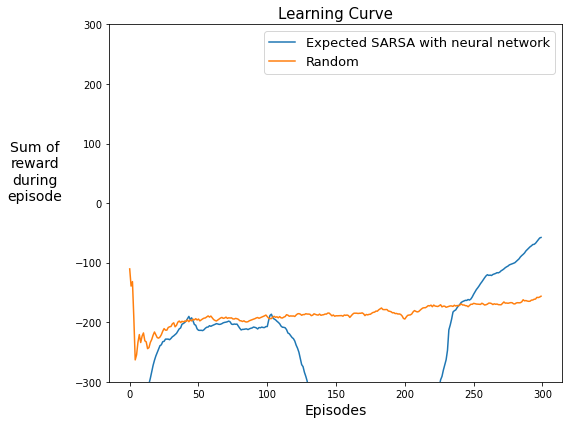

In [21]:
plot_result(["expected_sarsa_agent", "random_agent"])

In the following cell you can visualize the performance of the agent with a correct implementation. As you can see, the agent initially crashes quite quickly (Episode 0). Then, the agent learns to avoid crashing by expending fuel and staying far above the ground. Finally however, it learns to land smoothly within the landing zone demarcated by the two flags (Episode 275).

In [22]:
%%HTML
<div align="middle">
<video width="80%" controls>
      <source src="ImplementYourAgent.mp4" type="video/mp4">
</video></div>

In the learning curve above, you can see that sum of reward over episode has quite a high-variance at the beginning. However, the performance seems to be improving. The experiment that you ran was for 300 episodes and 1 run. To understand how the agent performs in the long run, we provide below the learning curve for the agent trained for 3000 episodes with performance averaged over 30 runs.
<img src="3000_episodes.png" alt="Drawing" style="width: 500px;"/>
You can see that the agent learns a reasonably good policy within 3000 episodes, gaining sum of reward bigger than 200. Note that because of the high-variance in the agent performance, we also smoothed the learning curve. 

### Wrapping up! 

You have successfully implemented Course 4 Programming Assignment 2.

You have implemented an **Expected Sarsa agent with a neural network and the Adam optimizer** and used it for solving the Lunar Lander problem! You implemented different components of the agent including:

- a neural network for function approximation,
- the Adam algorithm for optimizing the weights of the neural network,
- a Softmax policy,
- the replay steps for updating the action-value function using the experiences sampled from a replay buffer

You tested the agent for a single parameter setting. In the next assignment, you will perform a parameter study on the step-size parameter to gain insight about the effect of step-size on the performance of your agent.